In [11]:
from helloga.environment import Environment
from helloga.individual import BinaryIndividual 
from helloga.crossover import SinglePointCrossOver
from helloga.selector import LeadingSelector
from helloga.fitness import WeightedSumFitness
import logging 
import numpy as np

In [12]:
import networkx as nx
import matplotlib.pyplot as plt
from icecream import ic

# TSP: Travelling Salesman Problem
- We know the distance between any pair of cities
- A salesman is going to travel every city only once and come back to where he starts

In [39]:
# The algorithm is always a maximizer of the fitness. So we set the distance vector with negative value.
dist = [ -x for x in [99,2,3,4,5,2,99,1,2,3,3,1,99,6,1,4,2,6,99,4,5,3,1,4,99]]

In [40]:
# Set up a distance matrix. For visualization only!
m = np.array(dist).reshape((5,5))
m[m==-99] = 0
m = -m
x, y = np.where(m != 0)
ic(m, x, y)


ic| m: array([[0, 2, 3, 4, 5],
              [2, 0, 1, 2, 3],
              [3, 1, 0, 6, 1],
              [4, 2, 6, 0, 4],
              [5, 3, 1, 4, 0]])
    x: array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4],
             dtype=int64)
    y: array([1, 2, 3, 4, 0, 2, 3, 4, 0, 1, 3, 4, 0, 1, 2, 4, 0, 1, 2, 3],
             dtype=int64)


(array([[0, 2, 3, 4, 5],
        [2, 0, 1, 2, 3],
        [3, 1, 0, 6, 1],
        [4, 2, 6, 0, 4],
        [5, 3, 1, 4, 0]]),
 array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4],
       dtype=int64),
 array([1, 2, 3, 4, 0, 2, 3, 4, 0, 1, 3, 4, 0, 1, 2, 4, 0, 1, 2, 3],
       dtype=int64))

{(0, 1): Text(0.654508480212244, 0.4755283023511464, '2'),
 (0, 2): Text(0.09549145273252935, 0.2938926212887637, '3'),
 (0, 3): Text(0.09549151233717518, -0.2938926630120157, '4'),
 (0, 4): Text(0.6545085547180512, -0.4755282248651067, '5'),
 (1, 2): Text(-0.2500000670552266, 0.7694208997980517, '1'),
 (1, 3): Text(-0.2500000074505807, 0.1816356154972723, '2'),
 (1, 4): Text(0.30901703493029536, 5.3644181319256745e-08, '3'),
 (2, 3): Text(-0.8090170349302954, -6.55651103964594e-08, '6'),
 (2, 4): Text(-0.24999999254941926, -0.18163562741820138, '1'),
 (3, 4): Text(-0.24999993294477343, -0.7694209117189807, '4')}

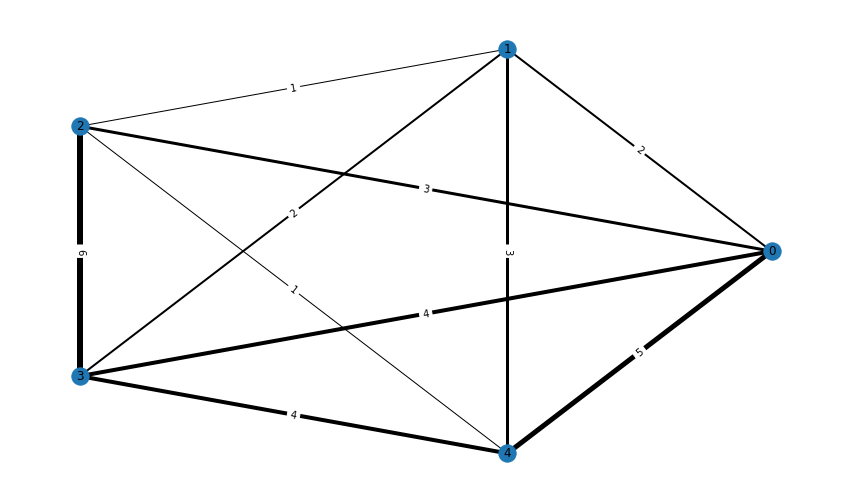

In [41]:
# create a graph and plot. For visualization only!
g = nx.Graph()
for xi, yj in zip(x,y) :
    g.add_edge(xi,yj, weight=m[xi,yj], color='black')
sg = g.subgraph(list(range(5)))
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")

edgewidth=[]
for u,v,d in g.edges(data=True):
    edgewidth.append(round(g.get_edge_data(u,v)['weight']*1,2))

plot_options = {"node_size": 300, "with_labels": True, "width": edgewidth, 'edge_color': [ g.edges[e]['color'] for e in g.edges]}
nx.draw_networkx(sg, pos=nx.circular_layout(sg), ax=ax, **plot_options)
labels = {e: g.edges[e]['weight'] for e in g.edges}
nx.draw_networkx_edge_labels(sg, pos=nx.circular_layout(sg), ax=ax, edge_labels=labels)

# We will visualize again after the algorithm with solutions

# Formulate the Problem
Assume we have 5 stops to travel around. Want to find a shortest path travelling every stop and return to starting stop. 

Define the chromosome as a 0-1 vector to represent each way between the 5 stops, we will have 5*(5-1)=20 ways in total. The problem is to find out a vector that minimize sum of way ***D***istence where every stop must be traveled once and first and last stop must be the same.   
$$ \min \sum_{ij}{D(x_{i},y_{j})} \quad where \quad i \in \{0, \dots, 4\}  $$
$$ s.t. \sum_{i}{x_i} = 1 $$
$$ \sum_{j}{y_j} = 1 $$
$$ \sum_{ij}{x_i y_j} = 5 $$


# Define the algorithm
## Intial parameters 
1. Chromosome: binary vector of size 25: it is a flattened vector of a 5*5 matrix(remove diagmeter).
2. Distance: a vector with same length and constant values and it is a flattened version of the symetric distance matrix.
## Evolving Operators
1. Fitness: sum of chromosome with weight from negative distance
3. Constraints: 
4. Survive Ratio: 0.5 means only top 50% of population can be survived for next reproducing iteration.
5. Mutation Rate: 0.1 by default, indicating that there is 10% probablity switch from 1 to 0 or inversed.
5. Crossover: crossover strategy can be customized, SinglePointCrossover is usually proper for binary cases. 


In [25]:
from itertools import product
from icecream import ic

# Define the constraints
def traval_only_once(individual, N) :
    arr = np.array(individual.chromosome).reshape((N, N))
    # ic(arr)
    sumx = np.sum(arr, axis=1)
    sumy = np.sum(arr, axis=0)
    diag = np.diag(arr)
    # ic(sumx, sumy, diag)
    return np.all(sumx==1) and np.all(sumy==1) and np.all(diag==0)
# ind = BinaryIndividual([1,1,0,0,0,0,0,0,0,1,1,0,1,1,0,0,0,0,1,1],0,0)

In [35]:
# Test the constraints
ind = BinaryIndividual([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],0,0)
traval_only_once(ind, 5)

True

# Define Hyperparameters 
- Initial Individuals: randomly initialized individuals will involve more possibility to find the best solution.
- Selection ratio: can be changed to a smaller value to make the algorithm faster and a larger value to keep more candidates. 


# Algorithm Steps
1. Initialize: input parameters and create algorithm instance
1. Calculate fitness: calculate fitness value for every individual
1. Select: keep only the individuals fulfill the constrants
1. Reproduce: generate new individuals by mutation and crossover operator
1. Exit criteria: check if stop criteria is fulfilled. If yes, stop the progress, otherwise repeat from step 2.  

In [18]:
# Create several feasible individuals. Otherwise all of them will be excluded at selection step.
individuals = [ 
    BinaryIndividual([0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0],0,0),
    BinaryIndividual([0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0],0,0),
    BinaryIndividual([0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0],0,0),
    BinaryIndividual([0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0],0,0),
    BinaryIndividual([0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0],0,0),
    BinaryIndividual([0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0],0,0),
]    

In [19]:
# Define selector
sel = LeadingSelector(
    ratio = 0.5,
    constraints=[lambda x: traval_only_once(x, 5)]
)

# Define fitness
fit = WeightedSumFitness(weights = dist)

# Define crossover operator
xo = SinglePointCrossOver()


In [28]:
# Create environment 
env = Environment(
    individuals, # initial individuals with at least one feasible solution
    selector=sel, 
    crossover=xo, 
    fitness_func=fit,
    MAX_GENERATION=50, # stop criterion by generation(every time crossover op is called, the individual will be added 1 generation)
    CAPACITY=100, # total individuals in the environment could not exceed this number, otherwise cull the population until population is smaller than capacity.
    MAX_ITERATION=100, # stop when the algorithm iterates to max times. 
    verbose=1, # show log ever step
)


In [29]:
# Run algorithm
env.evolute()

# Show population size and generation in the final state. 
print(env.species.population(), env.species.generations())


2022-11-14 14:44:41,278 - Species - INFO - ITERATION START -- : 0
2022-11-14 14:44:41,280 - Species - DEBUG - FITNESS - top:-16; sum: -96; avg:-16.0; population:6
2022-11-14 14:44:41,282 - Species - DEBUG - SELECTION -- top:-16; sum: -48; avg:-16.0; population:3
2022-11-14 14:44:41,282 - Species - DEBUG - PUNISHMENT -- population: 3, diversity:0
2022-11-14 14:44:41,284 - Species - DEBUG - MUTATION -- population: 6; generation: 0
2022-11-14 14:44:41,288 - Species - DEBUG - XOVER -- population: 36; generation: 1
2022-11-14 14:44:41,293 - Species - DEBUG - FEASIBLE -- top:-16; sum: -48; avg:-16.0; population:18
2022-11-14 14:44:41,295 - Species - DEBUG - FITNESS - top:-16; sum: -288; avg:-16.0; population:18
2022-11-14 14:44:41,297 - Species - DEBUG - SELECTION -- top:-16; sum: -144; avg:-16.0; population:9
2022-11-14 14:44:41,297 - Species - DEBUG - PUNISHMENT -- population: 9, diversity:0
2022-11-14 14:44:41,299 - Species - DEBUG - MUTATION -- population: 18; generation: 1
2022-11-14 14

88 51


In [31]:
# Find best 3 solutions if any
print('The best 3 solutions are: ')
for sol in env.getSolution(3) :
    print(sol) 


The best 3 solutions are: 
[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]
[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]
[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]


In [42]:
# Build the solutions in the graph. For visualization only!
msol = np.array(sol.chromosome).reshape((5,5))
x, y = np.where(msol==1)
for xi, yj in zip(x,y) :
    g.add_edge(xi,yj, weight=m[xi,yj], color='orange')
ic(msol)

ic| msol: array([[0, 0, 1, 0, 0],
                 [1, 0, 0, 0, 0],
                 [0, 0, 0, 0, 1],
                 [0, 1, 0, 0, 0],
                 [0, 0, 0, 1, 0]])


array([[0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0]])

{(0, 1): Text(0.654508480212244, 0.4755283023511464, '2'),
 (0, 2): Text(0.09549145273252935, 0.2938926212887637, '3'),
 (0, 3): Text(0.09549151233717518, -0.2938926630120157, '4'),
 (0, 4): Text(0.6545085547180512, -0.4755282248651067, '5'),
 (1, 2): Text(-0.2500000670552266, 0.7694208997980517, '1'),
 (1, 3): Text(-0.2500000074505807, 0.1816356154972723, '2'),
 (1, 4): Text(0.30901703493029536, 5.3644181319256745e-08, '3'),
 (2, 3): Text(-0.8090170349302954, -6.55651103964594e-08, '6'),
 (2, 4): Text(-0.24999999254941926, -0.18163562741820138, '1'),
 (3, 4): Text(-0.24999993294477343, -0.7694209117189807, '4')}

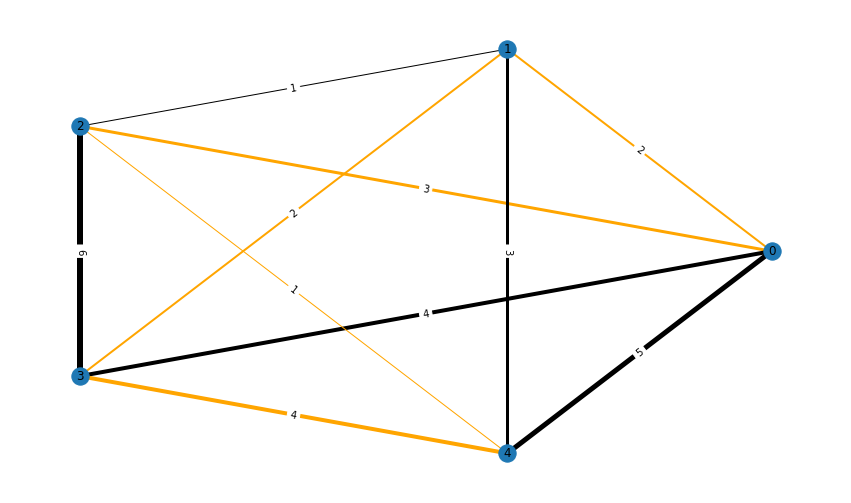

In [43]:
# Pick 50 nodes and draw for a first look
sg = g.subgraph(list(range(5)))
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")

edgewidth=[]
for u,v,d in g.edges(data=True):
    edgewidth.append(round(g.get_edge_data(u,v)['weight']*1,2))

plot_options = {"node_size": 300, "with_labels": True, "width": edgewidth, 'edge_color': [ g.edges[e]['color'] for e in g.edges]}
nx.draw_networkx(sg, pos=nx.circular_layout(sg), ax=ax, **plot_options)
labels = {e: g.edges[e]['weight'] for e in g.edges}
nx.draw_networkx_edge_labels(sg, pos=nx.circular_layout(sg), ax=ax, edge_labels=labels)
